In [1]:
# Imports and global definitions
"""
Requirements
pip install scipy==1.9.3 scanpy igraph harmonypy gseapy ipywidgets
"""
import os

import anndata as ad
import scanpy as sc
import scipy.stats as ss
import pandas as pd
import harmonypy as hm
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt

# Suppress Pandas warnings
pd.set_option('future.no_silent_downcasting', True)

# Define File Names
H5_FILENAME = 'GSE178341_crc10x_full_c295v4_submit.h5'
H5AD_FILENAME = H5_FILENAME.replace('.h5', '.h5ad')

CYTOTRACE_INPUT = 'cytotrace_input_normalized.csv'
CYTOTRACE_OUTPUT = 'CytoTRACE_scores.csv'

QC_FILENAME = 'GSE178341_QC.h5ad'

CLUSTER_FILENAME = 'GSE178341_crc10x_full_c295v4_submit_cluster.csv'
METADATA_FILENAME = 'GSE178341_crc10x_full_c295v4_submit_metatables.csv'

GSEA_RESULTS_DIR = "GSEA_results"
GSEA_TFRESULTS_DIR = "GSEA_tfresults"
GSEA_RANKED_GENES = "gsea_ranked_genes.rnk"
GSEA_RANKED_GENES_NORMAL_TUMOR = "gsea_ranked_genes_normalt.rnk"
TFT_GENE_SET = "c3.tft.v2024.1.Hs.symbols.gmt"

In [2]:
# Convert h5 to h5AD (Roughly 10 minutes)
if os.path.exists(H5_FILENAME) and not (os.path.exists(H5AD_FILENAME) or (os.path.exists(QC_FILENAME) and os.path.exists(CYTOTRACE_INPUT))):
    adata = sc.read_10x_h5(H5_FILENAME)
    adata.write_h5ad(H5AD_FILENAME)

In [3]:
# Create Gene Expression Table to Upload into CytoTRACE (Roughly 13 minutes)
if not os.path.exists(CYTOTRACE_INPUT):
    # Read h5AD File
    adata = sc.read_h5ad(H5AD_FILENAME)

    # Convert Sparse to Dense Matrix
    dense_matrix = adata.X.toarray()

    # Create DataFrame
    df = pd.DataFrame(
        dense_matrix.T,
        index=adata.var_names,  
        columns=adata.obs_names
    )

    # Export to CSV
    df.to_csv(CYTOTRACE_INPUT)

In [4]:
# Perform QC and filter out low-quality and highly-variable genes
if not os.path.exists(QC_FILENAME):
    # Read h5AD File
    adata = sc.read_h5ad(H5AD_FILENAME)

    # Identify mitochondrial genes (assuming human dataset with 'MT-' prefix)
    adata.var["mt"] = adata.var_names.str.startswith("MT-")

    # Compute QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Define QC thresholds
    min_genes = 200  # Cells must have at least 200 genes
    max_genes = 5000  # Remove cells with very high gene counts
    max_mt = 5  # Remove cells with >5% mitochondrial RNA

    # Apply filtering
    adata = adata[adata.obs.n_genes_by_counts > min_genes, :]
    adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
    adata = adata[adata.obs.pct_counts_mt < max_mt, :]

    # Filter Out Low-Quality Genes
    sc.pp.filter_genes(adata, min_cells=3)  # Keep genes present in at least 3 cells

    print(f"Remaining cells after filtering: {adata.n_obs}")

    # Normalize & Log-Transform Data for downstream analysis
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Identify Highly Variable Genes
    # Select genes that show high variability across cells
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # Keep only highly variable genes
    adata = adata[:, adata.var.highly_variable]

    print(f"Number of highly variable genes: {adata.shape[1]}")

    # Save the Processed Data
    adata.write(QC_FILENAME)

In [5]:
# Define merge_csv()
def merge_csv(adata: ad.AnnData, csv_filename: str, index_column: str, merge_column: str):
    # Prevent redundant merging
    if merge_column in adata.obs.columns:
        return

    # Read the CSV, extracting only the necessary columns
    csv = pd.read_csv(csv_filename)[[index_column, merge_column]]
    
    # Merge in the cluster information by matching the cell IDs
    adata.obs = adata.obs.reset_index()
    adata.obs = adata.obs.merge(csv, left_on='index', right_on=index_column, how='left')
    adata.obs = adata.obs.set_index('index')

    # Clean up duplicate column after merge
    adata.obs.drop(columns=[index_column], inplace=True)

In [6]:
# Read the QC file
adata = sc.read_h5ad(QC_FILENAME)

In [7]:
# Add CytoTRACE Scores to adata
if not os.path.exists(CYTOTRACE_OUTPUT):
    raise FileNotFoundError(f"Unable to find {CYTOTRACE_OUTPUT}. Please run CytoTRACE on {CYTOTRACE_INPUT} to generate the output file to {CYTOTRACE_OUTPUT}")

cytotrace_scores = pd.read_csv(CYTOTRACE_OUTPUT, index_col=0)
adata.obs['CytoTRACE'] = cytotrace_scores['x'] # assumes CytoTRACE maintains cell order

In [8]:
# Format data for Batch Correction
"""
FORMAT obs_names = C[PatientID]_[Region]_[X]_[Y]_[Z]_c[Cluster]_v[Version]_[Barcode]
T, N, TA, TB → Sample Type / Region
    T → Tumor sample
    N → Normal (adjacent) tissue
    TA, TB → Multiple tumor regions (possibly from different sections of the same tumor or replicates from the same patient)
"""
obs_names = adata.obs_names.str.split('_')
adata.obs["batch"] = obs_names.str[0]     # Patient IDs
adata.obs["region"] = obs_names.str[1]    # Sample Regions ()
display(adata.obs["batch"].value_counts())  # Number of cells per patient sample
display(adata.obs["region"].value_counts())

batch
C129    6895
C126    6013
C132    5579
C124    5026
C130    4283
        ... 
C168      90
C160      86
C172      83
C173      75
C161      33
Name: count, Length: 62, dtype: int64

region
T     61539
N     28852
TA     2960
TB     1942
Name: count, dtype: int64

In [9]:
# Read metadata
merge_csv(adata, METADATA_FILENAME, 'cellID', 'MMRStatus')

# Read Cell Type
merge_csv(adata, CLUSTER_FILENAME, 'sampleID', 'clTopLevel')
merge_csv(adata, CLUSTER_FILENAME, 'sampleID', 'clMidwayPr')


In [10]:
# Subset the data to only MMRD and MMRP cells
adata_sub = adata[adata.obs['MMRStatus'].isin(['MMRp', 'MMRd'])].copy()

# Perform DE Analysis 
sc.tl.rank_genes_groups(adata_sub, groupby="MMRStatus", method="wilcoxon")

# Extract DE results for MMRD vs MMRP
de_results = sc.get.rank_genes_groups_df(adata_sub, group="MMRd")

# Handle extreme values safely
de_results["pvals"] = de_results["pvals"].replace(0, 1e-300) # Avoid log(0) errors
de_results["logfoldchanges"] = de_results["logfoldchanges"].replace([np.inf, -np.inf], np.nan)

# Fill NaNs in logFC with 0 (neutral effect) & p-values with 1 (not significant)
de_results.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save Results
de_results.to_csv("MMRD_vs_MMRP_DEGs.csv", index=False)

# Show top genes
display(de_results.head(10))

,names,scores,logfoldchanges,pvals,pvals_adj
0,MT2A,52.256943,1.375977,1.000000e-300,0.000000e+00
1,CCL5,44.651451,1.872918,1.000000e-300,0.000000e+00
2,GZMB,43.182892,2.084113,1.000000e-300,0.000000e+00
3,GZMA,41.995499,1.913632,1.000000e-300,0.000000e+00
4,CCL4,39.764549,1.579251,1.000000e-300,0.000000e+00
5,NKG7,34.843288,1.526161,5.380654e-266,2.006087e-263
6,GNLY,32.978855,2.067555,1.632649e-238,5.217480e-236
7,CXCL13,30.376179,2.658653,1.133780e-202,3.170333e-200
8,KLRD1,30.329231,1.960532,4.721102e-202,1.173456e-199
9,MT1E,29.355377,1.494465,2.040225e-189,4.563982e-187


In [11]:
# Create DE as Ranked List for GSEA (MMRp vs. MMRd)
# Set low p-value to avoid numerical instability
min_pval = 1e-50

# Replace small p-values with min_pval
de_results["safe_pval"] = de_results["pvals"].clip(lower=min_pval)

# Compute ranking score (logFC * -log10(p-value))
de_results["rank"] = de_results["logfoldchanges"] * -np.log10(de_results["safe_pval"])

# Handle infinities or NaNs
de_results["rank"] = de_results["rank"].replace([np.inf, -np.inf], np.nan)
de_results["rank"] = de_results["rank"].fillna(0)

# Save ranked list
de_results[["names", "rank"]].to_csv(GSEA_RANKED_GENES, sep="\t", index=False, header=False)

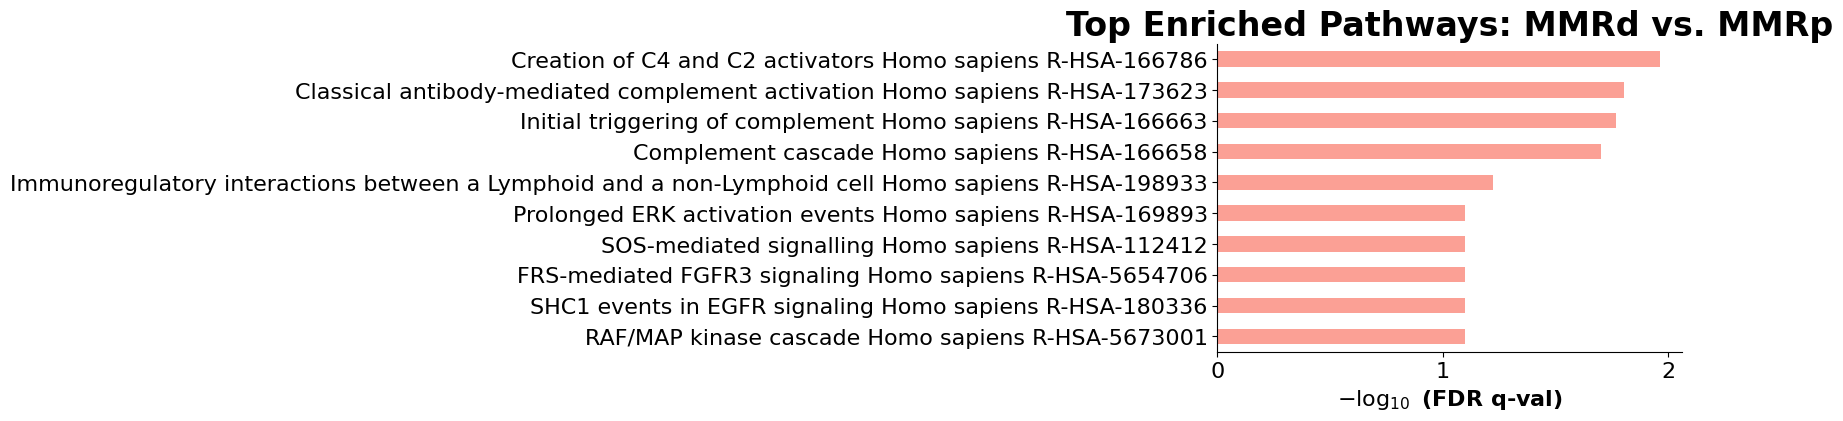

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Creation of C4 and C2 activators Homo sapiens ...,-0.960685,-1.69362,0.0,0.010858,0.008,4/25,0.31%,IGHG4;IGHG3;IGHG1;IGHG2
1,prerank,Classical antibody-mediated complement activat...,-0.961017,-1.662383,0.0,0.015744,0.015,4/23,0.31%,IGHG4;IGHG3;IGHG1;IGHG2
2,prerank,Initial triggering of complement Homo sapiens ...,-0.914751,-1.6494,0.0,0.01701,0.022,4/28,0.31%,IGHG4;IGHG3;IGHG1;IGHG2
3,prerank,Complement cascade Homo sapiens R-HSA-166658,-0.894059,-1.638904,0.0,0.019815,0.032,4/34,0.31%,IGHG4;IGHG3;IGHG1;IGHG2
4,prerank,Signaling by Wnt Homo sapiens R-HSA-195721,-0.87387,-1.519882,0.013937,0.247119,0.409,10/24,9.66%,TCF4;HIST1H2AC;CAV1;AXIN2;TLE2;GNG11;TLE4;RNF4...


In [12]:
# Gene Set Enrichment Analysis Between MMRd and MMRp
gsea_results = gp.prerank(
    rnk=GSEA_RANKED_GENES,
    gene_sets="Reactome_2016",  
    outdir=GSEA_RESULTS_DIR,
    seed=123,
    min_size=10,
    max_size=15000
)

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="Top Enriched Pathways: MMRd vs. MMRp",
    figsize=(6, 4),
    column="FDR q-val",  # Use the correct column name here
    cutoff=0.5
)
plt.show()

# View the results
display(gsea_results.res2d.head())

In [13]:
# Subset Tumor and Tumor Adjacent Normal Cells
adata_tumor = adata[adata.obs['region'] == 'T'].copy()
adata_normal = adata[adata.obs['region'] == 'N'].copy()
adata_combo = ad.concat([adata_normal, adata_tumor], label="group", keys=["Normal", "Tumor"])

# Add a new column to indicate the group (Normal vs Tumor)
adata_combo.obs['group'] = ['Normal'] * len(adata_normal) + ['Tumor'] * len(adata_tumor)

In [14]:
# Perform DE Analysis on Tumor and Tumor Adjacent Normal Cells
sc.tl.rank_genes_groups(adata_combo, groupby="group", method="wilcoxon")
de_results_normalt = sc.get.rank_genes_groups_df(adata_combo, group="Tumor")

# Handle extreme values safely
de_results_normalt["pvals"] = de_results_normalt["pvals"].replace(0, 1e-315)  # Avoid log(0) errors
de_results_normalt["logfoldchanges"] = de_results_normalt["logfoldchanges"].replace([np.inf, -np.inf], np.nan)

# Fill NaNs in logFC with 0 & p-values with 1 
de_results_normalt.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save results to CSV
de_results_normalt.to_csv("Normal_vs_Tumor_DEGs.csv", index=False)

# Show top differentially expressed genes
display(de_results_normalt.head(15))

,names,scores,logfoldchanges,pvals,pvals_adj
0,SAT1,69.716988,1.603837,1.000000e-315,0.0
1,IFITM2,58.532425,1.713394,1.000000e-315,0.0
2,HLA-DRB1,57.451248,1.901219,1.000000e-315,0.0
3,HLA-DRA,56.911594,1.718589,1.000000e-315,0.0
4,HLA-DPB1,52.565212,1.564734,1.000000e-315,0.0
5,CD2,51.782337,2.352433,1.000000e-315,0.0
6,LYZ,51.408615,3.165063,1.000000e-315,0.0
7,IFITM3,50.146790,1.966421,1.000000e-315,0.0
8,TXN,49.224968,1.124350,1.000000e-315,0.0
9,CTSD,48.066059,1.877886,1.000000e-315,0.0


In [15]:
# Create DE as Ranked List for GSEA (Tumor vs. Tumor Adjacent Normal)
# Replace extremely small p-values with min_pval
de_results_normalt["safe_pval"] = de_results_normalt["pvals"].clip(lower=min_pval)

# Compute ranking score (logFC * -log10(p-value))
de_results_normalt["rank"] = de_results_normalt["logfoldchanges"] * -np.log10(de_results["safe_pval"])

# Handle infinities or NaNs
de_results_normalt["rank"] = de_results_normalt["rank"].replace([np.inf, -np.inf], np.nan)
de_results_normalt["rank"] = de_results_normalt["rank"].fillna(0)

# Save ranked list
de_results_normalt[["names", "rank"]].to_csv(GSEA_RANKED_GENES_NORMAL_TUMOR, sep="\t", index=False, header=False)

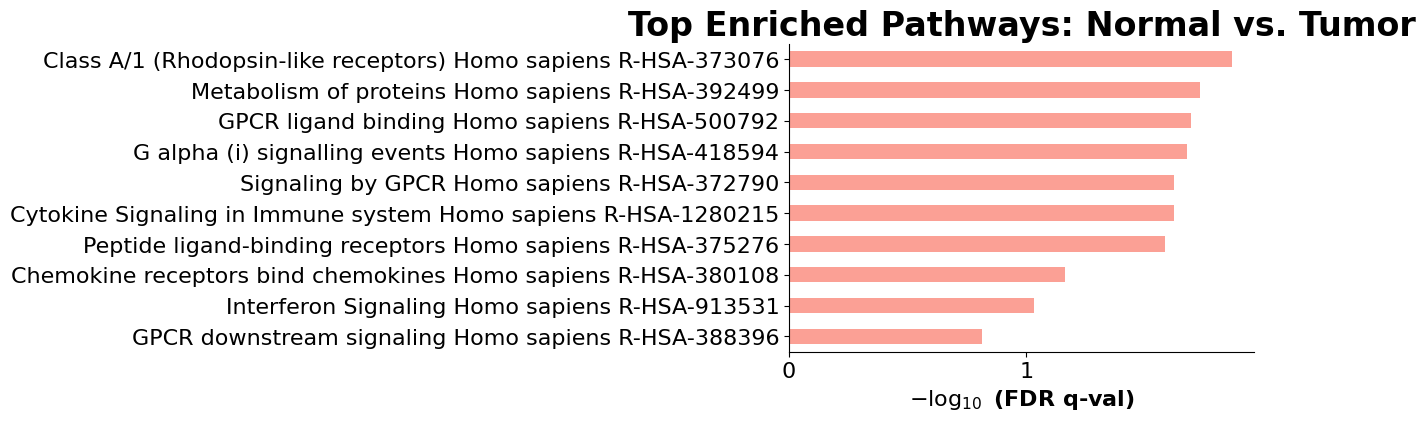

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,FCERI mediated NF-kB activation Homo sapiens R...,-0.922841,-1.547588,0.003676,0.426454,0.196,11/17,3.31%,IGHV3-23;IGLC7;IGKV4-1;IGKV1-5;IGLV7-46;IGLV2-...
1,prerank,Scavenging of heme from plasma Homo sapiens R-...,-0.916185,-1.52247,0.014493,0.347563,0.314,11/17,3.31%,IGHV3-23;IGLC7;IGKV4-1;IGKV1-5;IGLV7-46;IGLV2-...
2,prerank,Antigen activates B Cell Receptor (BCR) leadin...,-0.923723,-1.481505,0.015873,0.480535,0.568,6/12,2.73%,IGHV3-23;IGLC7;IGKV4-1;IGKV1-5;CD79B;IGLC6
3,prerank,Binding and Uptake of Ligands by Scavenger Rec...,-0.793829,-1.467365,0.051793,0.438175,0.645,15/31,6.93%,IGHV3-23;IGLC7;IGKV4-1;IGKV1-5;IGLV7-46;IGLV2-...
4,prerank,Biological oxidations Homo sapiens R-HSA-211859,-0.751626,-1.4614,0.049451,0.383287,0.683,8/40,8.00%,UGT2B17;ADH1C;ADH1B;SLC26A2;SULT1A2;SULT1B1;NR...


In [16]:
# Gene Set Enrichment Analysis Between Normal Tissue and Tumor Tissue
gsea_results = gp.prerank(
    rnk=GSEA_RANKED_GENES_NORMAL_TUMOR,
    gene_sets="Reactome_2016",  
    outdir=GSEA_RESULTS_DIR,
    seed=123,
    min_size=10,
    max_size=15000
)

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="Top Enriched Pathways: Normal vs. Tumor",
    figsize=(6, 4),
    column="FDR q-val", 
    cutoff=0.5
)
plt.show()

# View the results
display(gsea_results.res2d.head())

In [17]:
# Ensure TFT gene set is available
if not os.path.exists(TFT_GENE_SET):
    raise FileNotFoundError(f"Download the TFT gene set and rename it {TFT_GENE_SET} from https://www.gsea-msigdb.org/gsea/msigdb/download_file.jsp?filePath=/msigdb/release/2024.1.Hs/c3.tft.v2024.1.Hs.symbols.gmt")

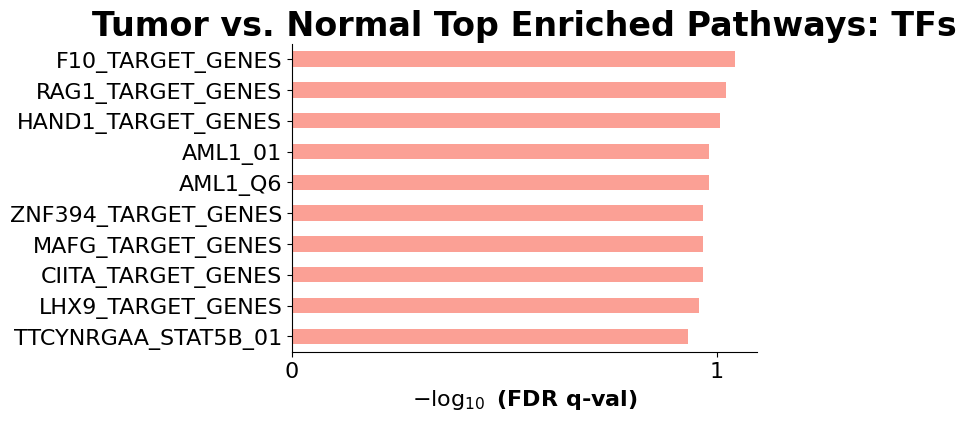

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,HNF1_01,-0.816232,-1.617096,0.0,0.23589,0.301,7/55,7.51%,GUCA2A;GUCA2B;SLC26A3;EFEMP1;SLC4A4;UGT2A3;NR1H4
1,prerank,COUP_DR1_Q6,-0.866013,-1.541744,0.008368,0.507333,0.735,5/31,4.20%,FABP1;SLC26A3;INSR;HMGCS2;EFEMP1
2,prerank,PPAR_DR1_Q2,-0.800541,-1.501033,0.022624,0.639198,0.903,4/38,4.20%,FABP1;INSR;HMGCS2;EFEMP1
3,prerank,DR1_Q3,-0.811464,-1.44475,0.041322,0.919576,0.983,5/31,9.57%,INSR;HMGCS2;EFEMP1;FBLN1;BCAM
4,prerank,HNF4_DR1_Q3,-0.744142,-1.43958,0.071429,0.77223,0.987,3/42,4.20%,FABP1;INSR;EFEMP1


In [18]:
# TF Associated with Tumor v.s. Normal Tissue
gsea_results = gp.prerank(
    rnk=GSEA_RANKED_GENES_NORMAL_TUMOR,
    gene_sets=TFT_GENE_SET,
    outdir=GSEA_TFRESULTS_DIR,
    permutation_num=1000,
    seed=42,
)

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="Tumor vs. Normal Top Enriched Pathways: TFs",
    figsize=(6, 4),
    column="FDR q-val", 
    cutoff=0.5
)
plt.show()

# View the results
display(gsea_results.res2d.head())

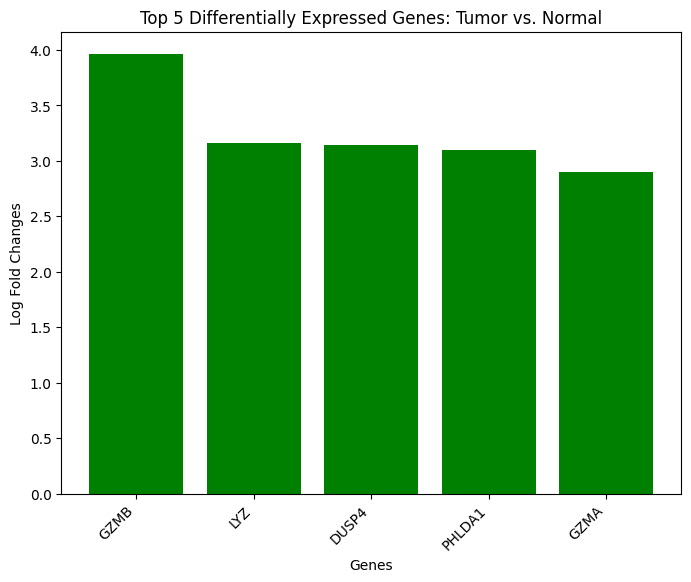

In [19]:
# Create a bar plot of top 5 DEGs
# Sort the DE results by p-value and logFC
de_results_sortednt = de_results_normalt.sort_values(by=['pvals', 'logfoldchanges'], ascending=[True, False])
top_5_genes = de_results_sortednt.head(5)

plt.figure(figsize=(8, 6))
plt.bar(top_5_genes["names"], top_5_genes["logfoldchanges"], color='green')
plt.xlabel("Genes")
plt.ylabel("Log Fold Changes")
plt.title("Top 5 Differentially Expressed Genes: Tumor vs. Normal")
plt.xticks(rotation=45, ha="right")  
plt.show()

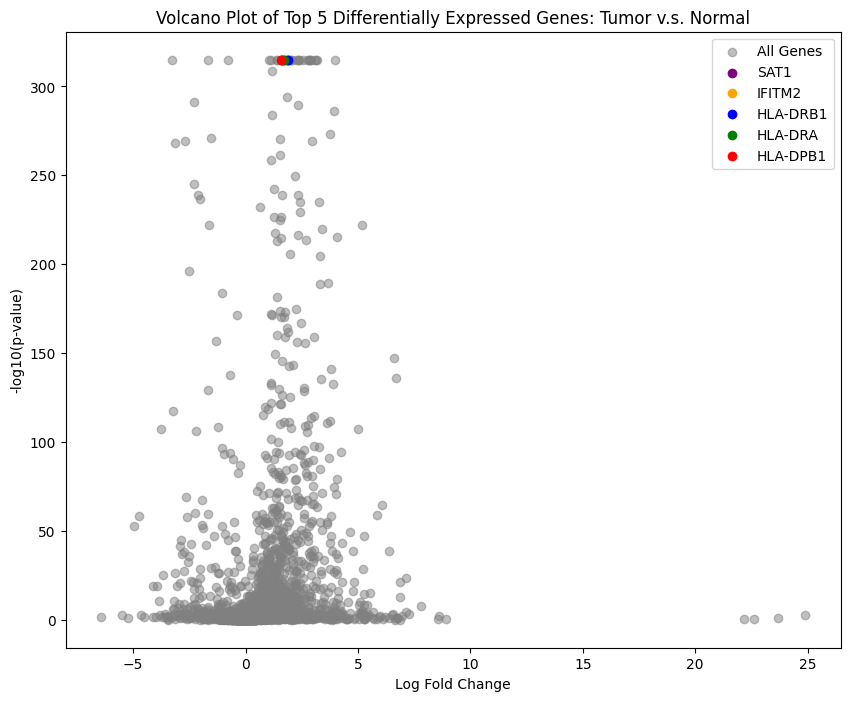

In [20]:
# Create Volcano Plot
plt.figure(figsize=(10, 8))

# Scatter plot for all genes
plt.scatter(de_results_normalt["logfoldchanges"],
            -np.log10(de_results_normalt["pvals"]),
            alpha=0.5,
            color='grey',
            label="All Genes")

# Highlight top 5 genes in red
top5 = de_results_normalt.iloc[:5]

# Plot top 5 points individually, with labels that will appear in the legend
point_colors = ['purple', 'orange', 'blue', 'green', 'red']
for i, row in top5.iterrows():
    plt.scatter(row["logfoldchanges"],
                -np.log10(row["pvals"]),
                color=point_colors[i],
                label=row["names"])

# Add labels and title
plt.xlabel('Log Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Top 5 Differentially Expressed Genes: Tumor v.s. Normal')

# Display one legend entry per label
handles, labels = plt.gca().get_legend_handles_labels()

# Remove duplicate labels (in case there are duplicates)
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.show()

In [21]:
# Subset the data to only MMRD and MMRP cells
adata_sub = adata[adata.obs['MMRStatus'].isin(['MMRp', 'MMRd'])].copy()

# Perform DE Analysis 
sc.tl.rank_genes_groups(adata_sub, groupby="MMRStatus", method="wilcoxon")

# Extract DE results for MMRD vs MMRP
de_results = sc.get.rank_genes_groups_df(adata_sub, group="MMRd")

# Handle extreme values safely
de_results["pvals"] = de_results["pvals"].replace(0, 1e-300) # Avoid log(0) errors
de_results["logfoldchanges"] = de_results["logfoldchanges"].replace([np.inf, -np.inf], np.nan)

# Fill NaNs in logFC with 0 (neutral effect) & p-values with 1 (not significant)
de_results.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save Results
de_results.to_csv("MMRD_vs_MMRP_DEGs.csv", index=False)

# Show top genes
display(de_results.head(10))

,names,scores,logfoldchanges,pvals,pvals_adj
0,MT2A,52.256943,1.375977,1.000000e-300,0.000000e+00
1,CCL5,44.651451,1.872918,1.000000e-300,0.000000e+00
2,GZMB,43.182892,2.084113,1.000000e-300,0.000000e+00
3,GZMA,41.995499,1.913632,1.000000e-300,0.000000e+00
4,CCL4,39.764549,1.579251,1.000000e-300,0.000000e+00
5,NKG7,34.843288,1.526161,5.380654e-266,2.006087e-263
6,GNLY,32.978855,2.067555,1.632649e-238,5.217480e-236
7,CXCL13,30.376179,2.658653,1.133780e-202,3.170333e-200
8,KLRD1,30.329231,1.960532,4.721102e-202,1.173456e-199
9,MT1E,29.355377,1.494465,2.040225e-189,4.563982e-187


In [22]:
# Subset Immune Cells
immune_categories = ['TNKILC', 'Myeloid', 'B', 'Mast', 'Plasma']
adata_immune = adata[adata.obs['clTopLevel'].isin(immune_categories)].copy()
display(adata_immune.obs['clTopLevel'].value_counts())

clTopLevel
TNKILC     27736
Plasma     26605
Myeloid    13133
B           7925
Mast        1459
Name: count, dtype: int64

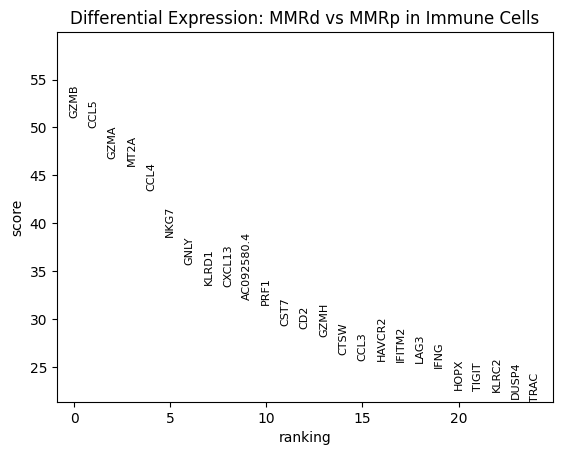

In [23]:
# Run Differential Expression for Immune Cells
sc.tl.rank_genes_groups(adata_immune, groupby='MMRStatus', groups=['MMRd'], reference='MMRp', method='wilcoxon')
sc.pl.rank_genes_groups(adata_immune, n_genes=25, sharey=False, show=False)
plt.title('Differential Expression: MMRd vs MMRp in Immune Cells')
plt.show()

In [24]:
# Separate dataset into MMRp and MMRd
adata_MMRp = adata_immune[adata_immune.obs['MMRStatus'] == 'MMRp'].copy()
adata_MMRd = adata_immune[adata_immune.obs['MMRStatus'] == 'MMRd'].copy()

In [25]:
# Relative Abundance Analysis
mmrp_counts = adata_MMRp.obs['clTopLevel'].value_counts(normalize=True) * 100
mmrd_counts = adata_MMRd.obs['clTopLevel'].value_counts(normalize=True) * 100

abundance_df = pd.DataFrame({
    'MMRp (%)': mmrp_counts,
    'MMRd (%)': mmrd_counts,
}, index=adata_immune.obs['clTopLevel'].unique())

display(abundance_df)

# Confirm Significance of Relative Abundance with Chi-Square Test
chi2, p, dof, expected = ss.chi2_contingency(abundance_df)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

,MMRp (%),MMRd (%)
Myeloid,23.165547,23.709001
Plasma,25.356604,13.685022
Mast,2.448224,1.357369
TNKILC,37.714305,55.215381
B,11.315320,6.033228


Chi-square statistic: 8.712374760159877
P-value: 0.06870488556599738


In [26]:
# Perform PCA and clustering
# For MMRp
sc.tl.pca(adata_MMRp, svd_solver='arpack')
sc.pp.neighbors(adata_MMRp, n_neighbors=10, n_pcs=40)

# For MMRd
sc.tl.pca(adata_MMRd, svd_solver='arpack')
sc.pp.neighbors(adata_MMRd, n_neighbors=10, n_pcs=40)

In [27]:
# Run Harmony for batch correction (2 minutes)
adata_MMRp.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRp.obsm["X_pca"], adata_MMRp.obs, 'batch').Z_corr.T # transpose result to fit expected shape
adata_MMRd.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRd.obsm["X_pca"], adata_MMRd.obs, 'batch').Z_corr.T

2025-03-16 16:03:42,210 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-16 16:03:56,574 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-16 16:03:56,913 - harmonypy - INFO - Iteration 1 of 10
2025-03-16 16:04:13,825 - harmonypy - INFO - Iteration 2 of 10
2025-03-16 16:04:29,961 - harmonypy - INFO - Iteration 3 of 10
2025-03-16 16:04:51,286 - harmonypy - INFO - Converged after 3 iterations
2025-03-16 16:04:51,415 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-16 16:05:01,536 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-16 16:05:02,217 - harmonypy - INFO - Iteration 1 of 10
2025-03-16 16:05:18,121 - harmonypy - INFO - Iteration 2 of 10
2025-03-16 16:05:30,653 - harmonypy - INFO - Iteration 3 of 10
2025-03-16 16:05:43,702 - harmonypy - INFO - Iteration 4 of 10
2025-03-16 16:05:55,438 - harmonypy - INFO - Iteration 5 of 10
2025-03-16 16:06:00,854 - harmonypy - INFO - Converged after

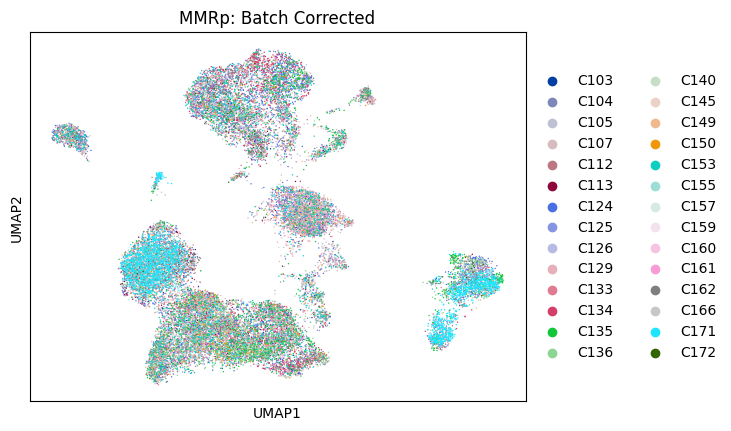

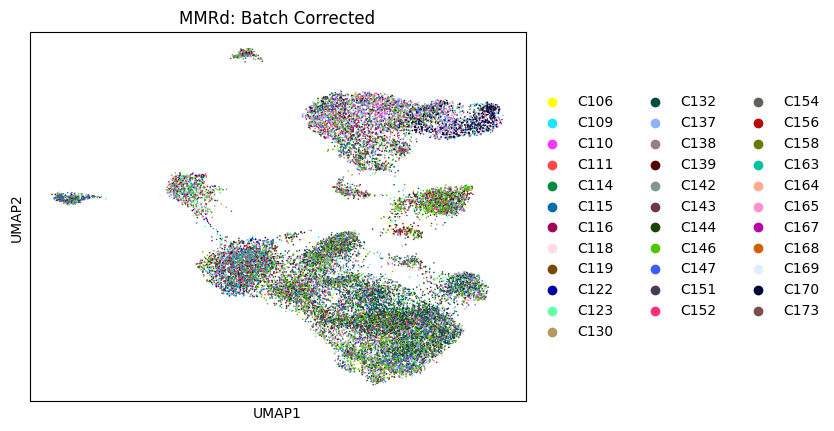

In [28]:
# Update neighbors & recompute UMAP (1.5 minutes)
sc.pp.neighbors(adata_MMRp, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRp)
sc.pl.umap(adata_MMRp, color="batch", title="MMRp: Batch Corrected")

sc.pp.neighbors(adata_MMRd, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRd)
sc.pl.umap(adata_MMRd, color="batch", title="MMRd: Batch Corrected")

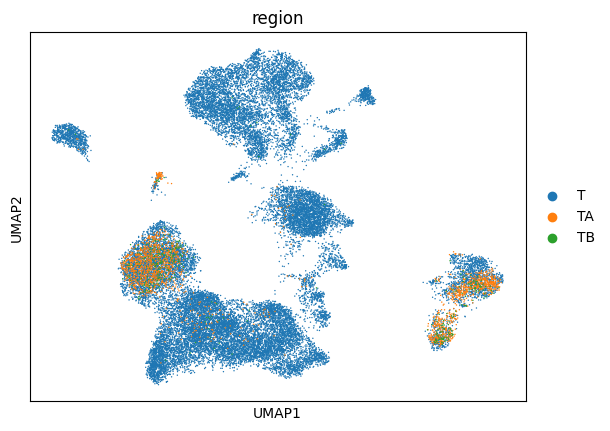

In [29]:
# Verify Teal Cluster is due to Biological Variation not Leftover Batch Effects
sc.pl.umap(adata_MMRp, color=['region'])

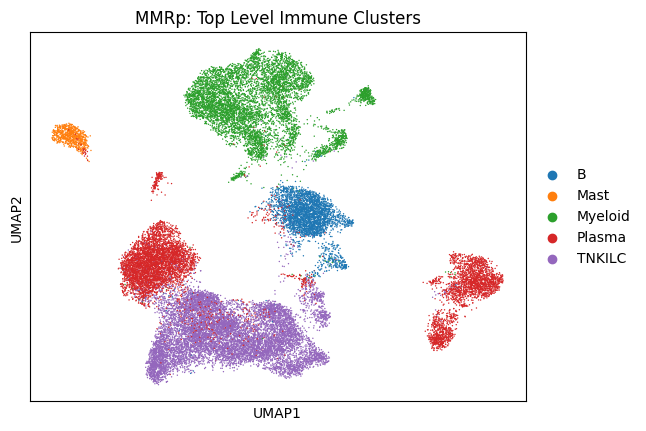

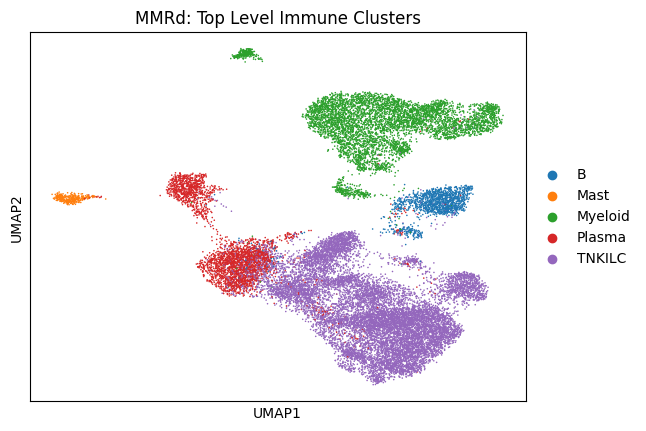

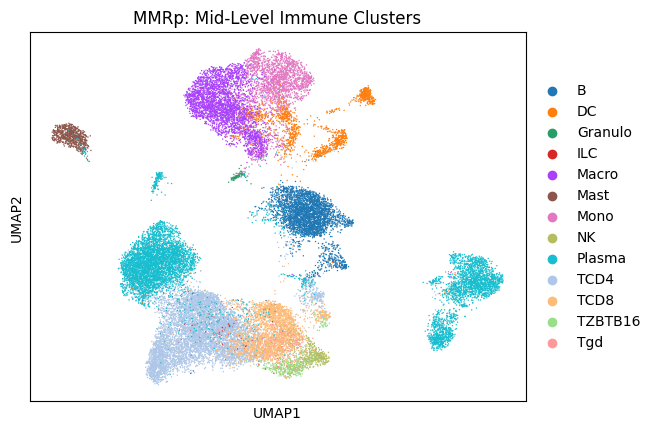

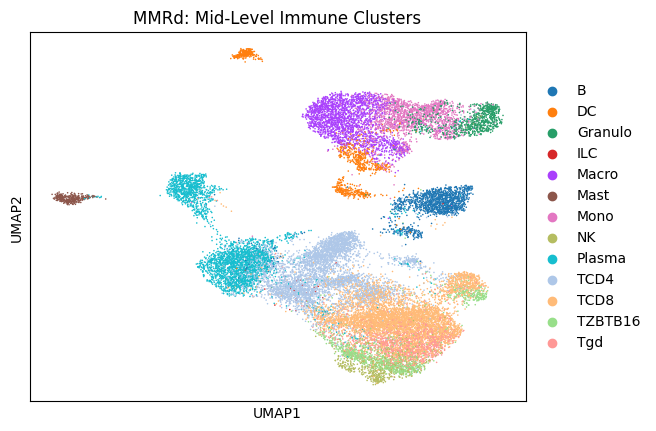

In [30]:
# Plot top-level UMAPs
sc.pl.umap(adata_MMRp, color='clTopLevel', title='MMRp: Top Level Immune Clusters')
sc.pl.umap(adata_MMRd, color='clTopLevel', title='MMRd: Top Level Immune Clusters')

# Plot mid-level UMAPs
sc.pl.umap(adata_MMRp, color='clMidwayPr', title='MMRp: Mid-Level Immune Clusters')
sc.pl.umap(adata_MMRd, color='clMidwayPr', title='MMRd: Mid-Level Immune Clusters')


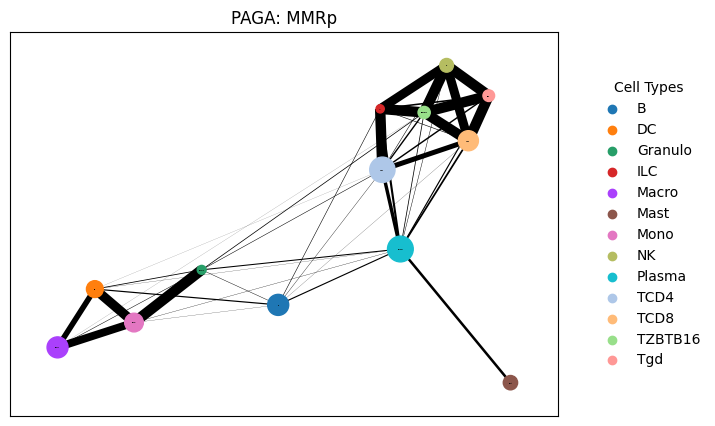

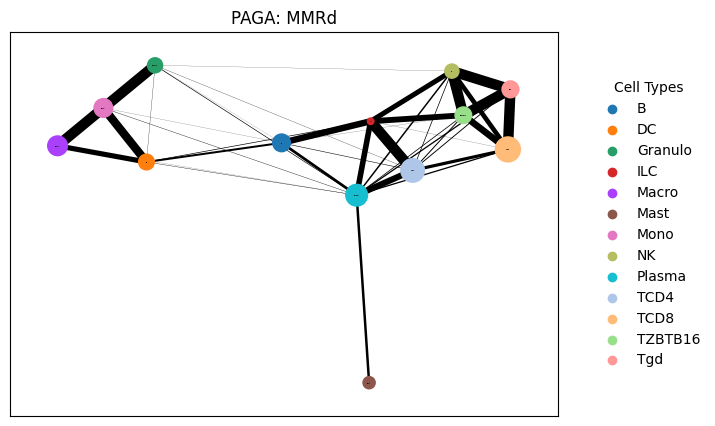

In [31]:
# Run PAGA for RNA Trajectory Analysis
sc.tl.paga(adata_MMRp, groups='clMidwayPr')
sc.tl.paga(adata_MMRd, groups='clMidwayPr')

# Plot PAGA Graph for MMRp
mmrp_paga = sc.pl.paga(adata_MMRp, color='clMidwayPr', fontsize=0, layout='fr',title='PAGA: MMRp', show=False)

# Get categories & colors
categories_mmrp = adata_MMRp.obs['clMidwayPr'].cat.categories
colors_mmrp = adata_MMRp.uns['clMidwayPr_colors']

# Create Legend
for label, color in zip(categories_mmrp, colors_mmrp):
    mmrp_paga.scatter([], [], color=color, label=label)

mmrp_paga.legend(loc='center left',
          bbox_to_anchor=(1.05, 0.5),
          frameon=False,
          title='Cell Types')
plt.show()

# Plot PAGA Graph for MMRd
mmrd_paga = sc.pl.paga(adata_MMRd, color='clMidwayPr', fontsize=0, layout='fr',title='PAGA: MMRd', show=False)

# Get categories & colors
categories_mmrd = adata_MMRd.obs['clMidwayPr'].cat.categories
colors_mmrd = adata_MMRd.uns['clMidwayPr_colors']

# Create Legend
for label, color in zip(categories_mmrd, colors_mmrd):
    mmrd_paga.scatter([], [], color=color, label=label)

mmrd_paga.legend(loc='center left',
          bbox_to_anchor=(1.05, 0.5),
          frameon=False,
          title='Cell Types')
plt.show()

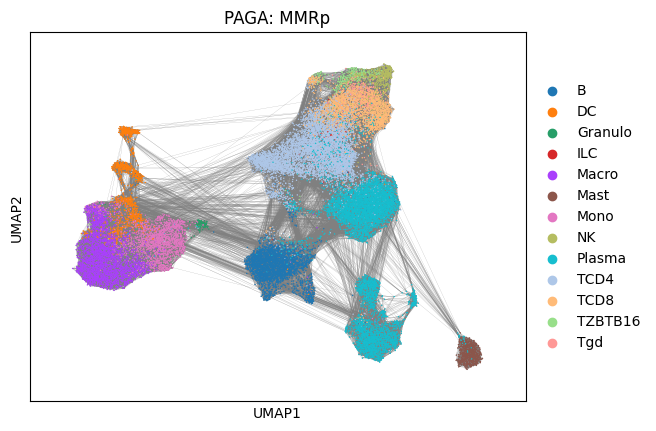

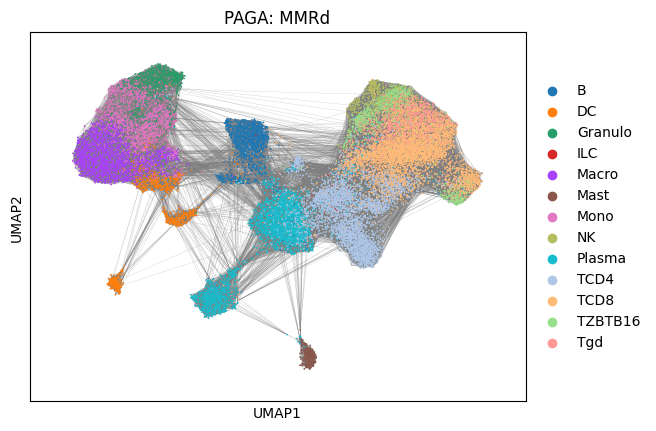

In [32]:
# Overlay PAGA on UMAP
sc.tl.umap(adata_MMRp, init_pos='paga')
sc.tl.umap(adata_MMRd, init_pos='paga')

sc.pl.umap(adata_MMRp, color=['clMidwayPr'], edges=True, title="PAGA: MMRp")
sc.pl.umap(adata_MMRd, color=['clMidwayPr'], edges=True, title="PAGA: MMRd")

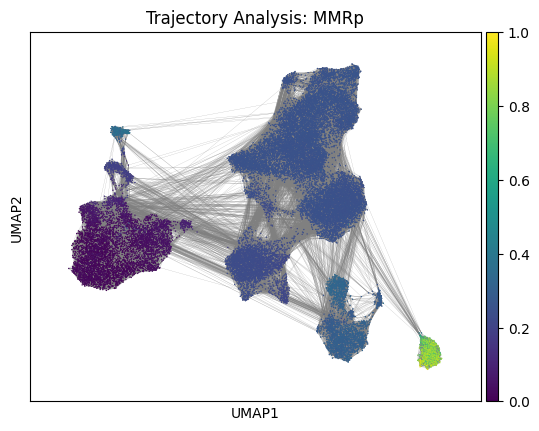

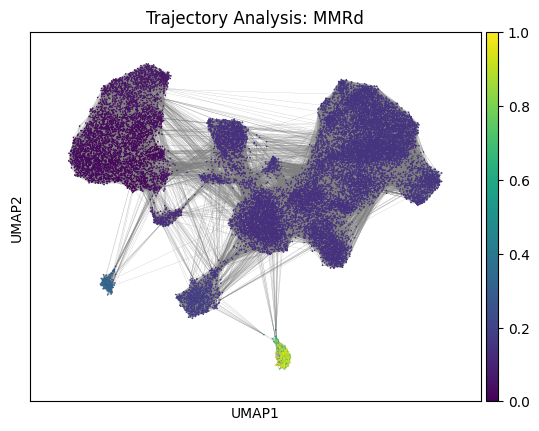

In [33]:
# Sort cells by CytoTRACE score (highest = most naive, less differentiated, more stem-like, high developmental potential)
sorted_cells_MMRp = adata_MMRp.obs.sort_values(by='CytoTRACE', ascending=False)
sorted_cells_MMRd = adata_MMRd.obs.sort_values(by='CytoTRACE', ascending=False)

# Pick the top-scoring cell
root_cell_index_MMRp = sorted_cells_MMRp.index[0]
root_cell_index_MMRd = sorted_cells_MMRd.index[0]

# Assign as the root in DPT
adata_MMRp.uns['iroot'] = adata_MMRp.obs_names.get_loc(root_cell_index_MMRp)
adata_MMRd.uns['iroot'] = adata_MMRd.obs_names.get_loc(root_cell_index_MMRd)

# Run Diffusion Pseudotime
sc.tl.diffmap(adata_MMRp)
sc.tl.dpt(adata_MMRp)
sc.tl.diffmap(adata_MMRd)
sc.tl.dpt(adata_MMRd)

# Plot DPT on UMAP (or original UMAP)
sc.pl.umap(adata_MMRp, color=['dpt_pseudotime'], edges=True, title='Trajectory Analysis: MMRp')
sc.pl.umap(adata_MMRd, color=['dpt_pseudotime'], edges=True, title='Trajectory Analysis: MMRd')